In [1]:
import math
from typing import TypeAlias

import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import seaborn as sns
import torch
import torch.linalg as LA

from transforms import MobiusMixtureTransform
from utils import metropolis_acceptance, effective_sample_size
from visualisations import scatter, pairplot

Tensor: TypeAlias = torch.Tensor

π = math.pi

sns.set_theme()

In [2]:
class CircularUniformPrior(torch.utils.data.IterableDataset):
    def __init__(self, sample_shape: int | list[int]):
        super().__init__()
        if not hasattr(sample_shape, "__iter__"):
            sample_shape = [sample_shape]
        if len(sample_shape) < 2:
            sample_shape += [1]
        self.shape = sample_shape

    def __iter__(self):
        return self

    def __next__(self):
        phi = torch.rand(self.shape) * 2 * π

        x = phi.cos()
        y = phi.sin()

        outputs = torch.stack([x, y], dim=-1)
        logq = (
            torch.full(self.shape, fill_value=-math.log(2 * π), device=outputs.device)
            .flatten(start_dim=1)
            .sum(dim=1)
        )

        return outputs, logq

In [3]:
class NormalizingFlowMobius(pl.LightningModule):
    def __init__(
        self,
        κ: float,
        ξ: float,
        n_layers: int,
        n_mixture: int,
        weighted: bool,
        batch_size: int,
        val_batch_size: int,
        epsilon: float = 1e-3,
        init_lr: float = 0.001,
    ):
        super().__init__()

        self.κ = κ
        self.ξ = ξ
        μ = torch.Tensor([math.cos(ξ), math.sin(ξ)])
        self.register_buffer("μ", μ)

        self.batch_size = batch_size
        self.val_batch_size = val_batch_size
        self.init_lr = init_lr

        self.log_norm = -math.log(2 * π * torch.i0(torch.tensor([κ])))

        self.transform = MobiusMixtureTransform(n_mixture, weighted, epsilon)
        self.params = torch.nn.Parameter(
            torch.stack(
                [
                    torch.rand_like(self.transform.identity_params)
                    for _ in range(n_layers)
                ],
                dim=0,
            )
        )

        # Random global rotations applied after each layer (potentially trainable)
        self.rotations = torch.nn.Parameter(torch.empty(n_layers).uniform_(0, 2 * π))
        self.save_hyperparameters()
        if self.logger is not None and type(self.logger) is TensorBoardLogger:
            self.logger.log_hyperparams(self.hparams)

    def forward(self, xy: Tensor) -> tuple[Tensor, Tensor]:
        ldj = torch.zeros(xy.shape[0], device=xy.device)

        for params, rotation in zip(self.params, self.rotations):
            # [-1, 1]
            params = params.expand(*xy.shape[:-1], -1)
            xy, ldj_this = self.transform(xy, params)

            costheta, sintheta = rotation.cos(), rotation.sin()
            R = torch.tensor(
                [[costheta, sintheta], [-sintheta, costheta]],
                device=xy.device,
            ).view(*[1 for _ in xy.shape[:-1]], 2, 2)
            xy_new = (R * xy.unsqueeze(-2)).sum(dim=-1)

            x, y = xy.split(1, dim=-1)
            xy = torch.cat(
                [x * costheta + y * sintheta, x * -sintheta + y * costheta], dim=-1
            )
            assert torch.allclose(xy, xy_new)

            ldj += ldj_this

        xy.squeeze_(dim=1)

        return xy, ldj

    def training_step(self, batch, *_):
        z, logq = batch
        x, ldj = self(z)
        logp = self.log_norm + self.κ * torch.mv(x, self.μ)

        kl_div = torch.mean(logq - ldj - logp)
        self.log("loss", kl_div)

        return kl_div

    def validation_step(self, batch, *_):
        z, logq = batch
        x, ldj = self(z)
        logp = self.log_norm + self.κ * torch.mv(x, self.μ)

        weights = logp - (logq - ldj)
        self.log("acceptance", metropolis_acceptance(weights))
        self.log("ess", effective_sample_size(weights))

        # Only TensorBoardLogger supported
        if self.logger is None or type(self.logger) is not TensorBoardLogger:
            return

    def test_step(self, batch, *_):
        z, logq = batch
        x, ldj = self(z)
        logp = self.log_norm + self.κ * torch.mv(x, self.μ)

        weights = logp - (logq - ldj)
        self.log("hp/acceptance", metropolis_acceptance(weights))
        self.log("hp/ess", effective_sample_size(weights))

    def train_dataloader(self):
        return CircularUniformPrior(self.batch_size)

    def val_dataloader(self):
        return CircularUniformPrior(self.val_batch_size)

    def test_dataloader(self):
        return self.val_dataloader()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.init_lr)

## A single Mobius transformation

In [4]:
model = NormalizingFlowMobius(
    κ=10,
    ξ=π / 2,
    n_layers=1,
    n_mixture=1,
    weighted=False,
    batch_size=2000,
    val_batch_size=8000,
    epsilon=1e-3,
    init_lr=0.01,
)

trainer = pl.Trainer(
    accelerator="auto",
    max_steps=2000,
    val_check_interval=50,
    limit_val_batches=1,
    limit_test_batches=1,
    num_sanity_val_steps=1,
    logger=False,
    enable_checkpointing=False,
)

trainer.fit(model)

(metrics,) = trainer.test(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
------------------------------
3         Trainable params
0         Non-trainable params
3         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=2000` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      hp/acceptance         0.5586948394775391
         hp/ess             0.5821323394775391
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


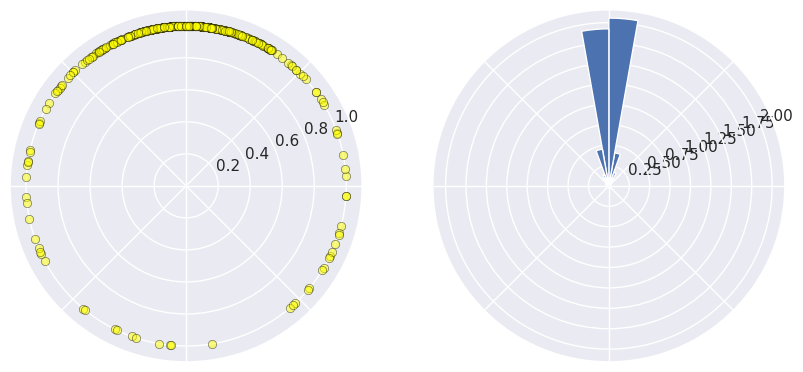

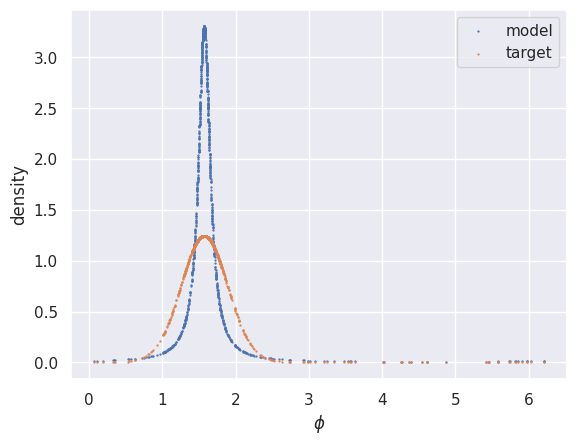

In [5]:
with torch.no_grad():
    xy_in, logq = next(CircularUniformPrior(1000))
    xy, ldj = model(xy_in)

r = LA.vector_norm(xy, dim=-1)
x, y = xy.split(1, dim=-1)
ϕ = torch.fmod(torch.atan2(y, x) + (2 * π), 2 * π)

hist, bins = torch.histogram(ϕ, bins=36, range=(0, 2 * π), density=True)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={"polar": True})
ax1.scatter(ϕ, r, edgecolor="black", facecolor="yellow", linewidths=0.5, alpha=0.5)
ax1.set_ylim([0, 1.1])
ax1.set_xticklabels([])

ax2.bar(
    0.5 * (bins[:-1] + bins[1:]), hist, width=(2 * π) / (len(bins) - 1), bottom=0.01
)
ax2.set_xticklabels([])


fig2, ax3 = plt.subplots()
ax3.set_xlabel(r"$\phi$")
ax3.set_ylabel("density")
ax3.scatter(ϕ, torch.exp(logq - ldj), s=0.4, label="model")
ax3.scatter(
    ϕ,
    torch.exp(model.log_norm + model.κ * torch.mv(xy, model.μ)),
    s=0.4,
    label="target",
)
ax3.legend()

## A mixture of Mobius transformations

In [6]:
model = NormalizingFlowMobius(
    κ=10,
    ξ=π / 2,
    n_layers=1,
    n_mixture=10,
    weighted=True,
    batch_size=2000,
    val_batch_size=8000,
    epsilon=1e-3,
    init_lr=0.01,
)

trainer = pl.Trainer(
    accelerator="auto",
    max_steps=2000,
    val_check_interval=50,
    limit_val_batches=1,
    limit_test_batches=1,
    num_sanity_val_steps=1,
    logger=False,
    enable_checkpointing=False,
)

trainer.fit(model)

(metrics,) = trainer.test(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
------------------------------
31        Trainable params
0         Non-trainable params
31        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=2000` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      hp/acceptance         0.9857482314109802
         hp/ess             0.9973657727241516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


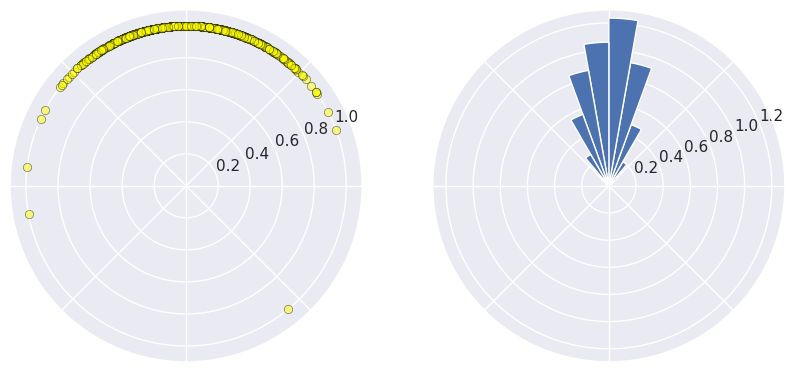

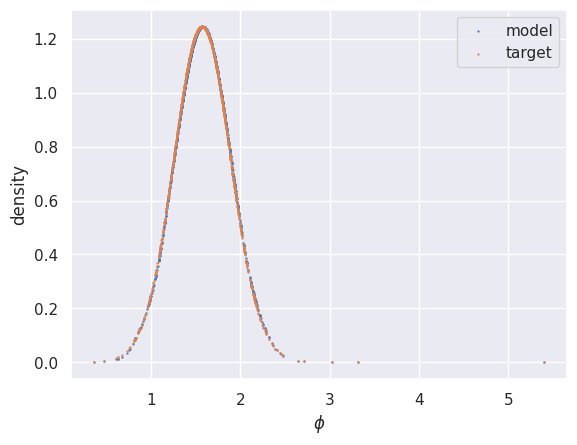

In [7]:
with torch.no_grad():
    xy_in, logq = next(CircularUniformPrior(1000))
    xy, ldj = model(xy_in)

r = LA.vector_norm(xy, dim=-1)
x, y = xy.split(1, dim=-1)
ϕ = torch.fmod(torch.atan2(y, x) + (2 * π), 2 * π)

hist, bins = torch.histogram(ϕ, bins=36, range=(0, 2 * π), density=True)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={"polar": True})
ax1.scatter(ϕ, r, edgecolor="black", facecolor="yellow", linewidths=0.5, alpha=0.5)
ax1.set_ylim([0, 1.1])
ax1.set_xticklabels([])

ax2.bar(
    0.5 * (bins[:-1] + bins[1:]), hist, width=(2 * π) / (len(bins) - 1), bottom=0.01
)
ax2.set_xticklabels([])

fig2, ax3 = plt.subplots()
ax3.set_xlabel(r"$\phi$")
ax3.set_ylabel("density")
ax3.scatter(ϕ, torch.exp(logq - ldj), s=0.4, label="model")
ax3.scatter(
    ϕ,
    torch.exp(model.log_norm + model.κ * torch.mv(xy, model.μ)),
    s=0.4,
    label="target",
)
ax3.legend()

In [8]:
x = torch.rand(2)
x = x / x.pow(2).sum().sqrt()

x1, x2 = x.split(1, dim=0)
phi = torch.atan2(x2, x1)  # .remainder(2 * π)

theta = torch.tensor([0])  # torch.rand(1)
R = torch.tensor(
    [
        [theta.cos(), -theta.sin()],
        [theta.sin(), theta.cos()],
    ]
)

ya = torch.cat(
    [
        x1 * theta.cos() + x2 * -theta.sin(),
        x1 * theta.sin() + x2 * theta.cos(),
    ]
)

yb = torch.mv(R, x)

yc = (R * x.unsqueeze(0)).sum(dim=-1)

phid = phi + theta  # .remainder(2 * π)
yd = torch.cat([phid.cos(), phid.sin()])

print(ya, yb, yc, yd)

phia = torch.atan2(ya[1], ya[0])
phib = torch.atan2(yb[1], yb[0])
phic = torch.atan2(yc[1], yc[0])
phidd = torch.atan2(yd[1], yd[0])

print(phia, phib, phic, phid, phidd)

tensor([0.9625, 0.2713]) tensor([0.9625, 0.2713]) tensor([0.9625, 0.2713]) tensor([0.9625, 0.2713])
tensor(0.2747) tensor(0.2747) tensor(0.2747) tensor([0.2747]) tensor(0.2747)
